### Import libraries

In [17]:
import pandas as pd
import numpy as np
import math
import re

### Loading datas

In [55]:
DATA_FOLDER = 'data'
FOOD_FILE = 'food_data.csv'
COUNTRIES_FILE = 'countries_info.csv'
OVERWEIGHT_FILE = 'overweight.csv'
DIABETES_FILE = 'diabetes.csv'


In [103]:
all_datas = pd.read_csv(DATA_FOLDER + "/" + FOOD_FILE, sep='\t')
countries_infos = pd.read_csv(DATA_FOLDER + "/" + COUNTRIES_FILE, sep=',')
overweight = pd.read_csv(DATA_FOLDER + "/" + OVERWEIGHT_FILE, sep=',')
diabetes = pd.read_csv(DATA_FOLDER + '/' + DIABETES_FILE)

/home/pirate/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0,3,5,24,25,26,28,35,36,41,49,52) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Analysis of the different fields available in the dataset

We have to select only the features which is possible to help us to answer our questions

In [20]:
for col in all_datas.columns.values:
    print("- ", col)

-  code
-  url
-  creator
-  created_t
-  created_datetime
-  last_modified_t
-  last_modified_datetime
-  product_name
-  generic_name
-  quantity
-  packaging
-  packaging_tags
-  brands
-  brands_tags
-  categories
-  categories_tags
-  categories_en
-  origins
-  origins_tags
-  manufacturing_places
-  manufacturing_places_tags
-  labels
-  labels_tags
-  labels_en
-  emb_codes
-  emb_codes_tags
-  first_packaging_code_geo
-  cities
-  cities_tags
-  purchase_places
-  stores
-  countries
-  countries_tags
-  countries_en
-  ingredients_text
-  allergens
-  allergens_en
-  traces
-  traces_tags
-  traces_en
-  serving_size
-  serving_quantity
-  no_nutriments
-  additives_n
-  additives
-  additives_tags
-  additives_en
-  ingredients_from_palm_oil_n
-  ingredients_from_palm_oil
-  ingredients_from_palm_oil_tags
-  ingredients_that_may_be_from_palm_oil_n
-  ingredients_that_may_be_from_palm_oil
-  ingredients_that_may_be_from_palm_oil_tags
-  nutrition_grade_uk
-  nutrition_grade_f

We can deduce the usefull colums for our project:
 - product_name
 - sugars_100g
 - fat_100g
 - nutrition_grade_fr
 - countries
 - countries_tags


### Datasets clean
We clean our datasets. We select only the potential interesting fields. 

We do some operations on the countries tags to be able to parse the data. We also remove potential outliers.

In [21]:
countries_infos = countries_infos[['COUNTRY_ALPHA2_CODE', 'COUNTRY_NAME']]

In [22]:
usefull_datas = all_datas[['product_name',
                   'countries',
                   'countries_tags',
                   'sugars_100g',
                   'fat_100g']]

usefull_datas['countries_tags'].replace(regex=True, inplace=True, to_replace=r'\w\w:', value=r'')
usefull_datas = usefull_datas[usefull_datas['sugars_100g'] <= 100]
usefull_datas = usefull_datas[usefull_datas['fat_100g'] <= 100]
        
usefull_datas

/home/pirate/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


,code,product_name,countries,countries_en,countries_tags,origins,origins_tags,manufacturing_places,first_packaging_code_geo,sugars_100g,fat_100g,glycemic-index_100g
0,0000000000017,Vitória crackers,en:france,France,france,NaN,NaN,NaN,NaN,15.00,7.00,NaN
2,0000000000123,Sauce Sweety chili 0%,en:france,France,france,NaN,NaN,NaN,NaN,0.40,0.00,NaN
4,0000000000949,Salade de carottes râpées,en:france,France,france,NaN,NaN,NaN,NaN,3.90,0.30,NaN
5,0000000000970,Fromage blanc aux myrtilles,en:france,France,france,NaN,NaN,NaN,NaN,16.30,4.90,NaN
8,0000000001137,Baguette parisien,en:france,France,france,NaN,NaN,NaN,NaN,1.80,3.30,NaN
9,0000000001151,&quot;Baguette Lyonnais&quot;,en:france,France,france,NaN,NaN,NaN,NaN,2.00,9.40,NaN
10,0000000001199,Solène céréales poulet,France,France,france,NaN,NaN,NaN,NaN,1.70,5.90,NaN
11,0000000001281,Tarte noix de coco,en:france,France,france,NaN,NaN,NaN,NaN,21.90,22.00,NaN
12,0000000001311,Salade de fruits exotiques,en:france,France,france,NaN,NaN,NaN,NaN,23.00,0.00,NaN
13,0000000001328,Chouquettes x 30,en:france,France,france,NaN,NaN,NaN,NaN,20.00,21.00,NaN


We contruct a datastructure with the countries codes map to their names (in different langages)

In [23]:
check = []

for c in usefull_datas['countries_tags'].dropna():
    for t in c.split(','):
        t = t.strip().lower()
        yolo = re.search('\w\w:(.+)', t, re.IGNORECASE)
        
        if yolo:
            t = yolo.group(1)
        
        if t not in check:
            check.append(t)

countries_with_code = []
countries_infos['COUNTRY_NAME'] = countries_infos['COUNTRY_NAME'].apply(lambda x: str(x).lower())

for c in check:
    is_present = False
    
    for index, c_i in countries_infos[countries_infos['COUNTRY_NAME'] == c.lower()].iterrows():
        countries_with_code.append((c, c_i['COUNTRY_ALPHA2_CODE']))
        is_present = True
        break
        
    if not is_present:
        countries_with_code.append((c, "???"))

We select only the countries with which we have informations.

In [24]:
count = 0
proper_countries = []

for c in countries_with_code:
    if c[1] != "???":
        proper_countries.append(c)
        

display(proper_countries)

[('france', 'FR'),
 ('canada', 'CA'),
 ('oman', 'OM'),
 ('germany', 'DE'),
 ('belgium', 'BE'),
 ('netherlands', 'NL'),
 ('australia', 'AU'),
 ('switzerland', 'CH'),
 ('egypt', 'EG'),
 ('mexico', 'MX'),
 ('italy', 'IT'),
 ('spain', 'ES'),
 ('saudi-arabia', 'SA'),
 ('iraq', 'IQ'),
 ('sverige', 'SE'),
 ('sweden', 'SE'),
 ('vietnam', 'VN'),
 ('singapore', 'SG'),
 ('thailand', 'TH'),
 ('greece', 'GR'),
 ('panama', 'PA'),
 ('malaysia', 'MY'),
 ('luxembourg', 'LU'),
 ('lebanon', 'LB'),
 ('denmark', 'DK'),
 ('guyana', 'GY'),
 ('serbia', 'RS'),
 ('martinique', 'MQ'),
 ('barbados', 'BB'),
 ('ireland', 'IE'),
 ('aruba', 'AW'),
 ('bahrain', 'BH'),
 ('taiwan', 'TW'),
 ('cuba', 'CU'),
 ('portugal', 'PT'),
 ('kuwait', 'KW'),
 ('austria', 'AT'),
 ('japan', 'JP'),
 ('israel', 'IL'),
 ('royaume-uni', 'GB'),
 ('brazil', 'BR'),
 ('morocco', 'MA'),
 ('guinea', 'GN'),
 ('china', 'CN'),
 ('algeria', 'DZ'),
 ('mauritius', 'MU'),
 ('indonesia', 'ID'),
 ('turkey', 'TR'),
 ('belgien', 'BE'),
 ('deutschland', 'DE

When a rows mention many countries we explode the dataframe to get one line for each country.

In [25]:
def get_tag(country_name):
    for c in proper_countries:
        if c[0] == country_name:
            return c[1]
        
    return "TBD"

rows = []

#Explode inital df
for index, data in usefull_datas.iterrows():
    countries = str(data['countries_tags']).split(',')
    
    for c in countries:
        data['countries_tags'] = get_tag(c.strip().lower())
        rows.append(data)
        

parsed_datas = pd.DataFrame(rows)

### Get results
Now we compute result from the parsed datasets

In [26]:
grouped = parsed_datas.groupby(['countries_tags'])
means = grouped.mean()
means

,sugars_100g,fat_100g,glycemic-index_100g
countries_tags,,,
AD,1.708000,6.512000,NaN
AL,8.925000,3.900000,NaN
AR,25.568333,17.087222,NaN
AT,8.482282,14.494228,NaN
AU,12.631958,10.899496,NaN
AW,8.000000,17.300000,NaN
AZ,0.000000,0.200000,NaN
BE,12.411555,14.417484,NaN
BG,30.115000,20.775000,NaN


In [27]:
grouped = parsed_datas.groupby(['countries_tags'])
counted = grouped.count()

/home/pirate/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


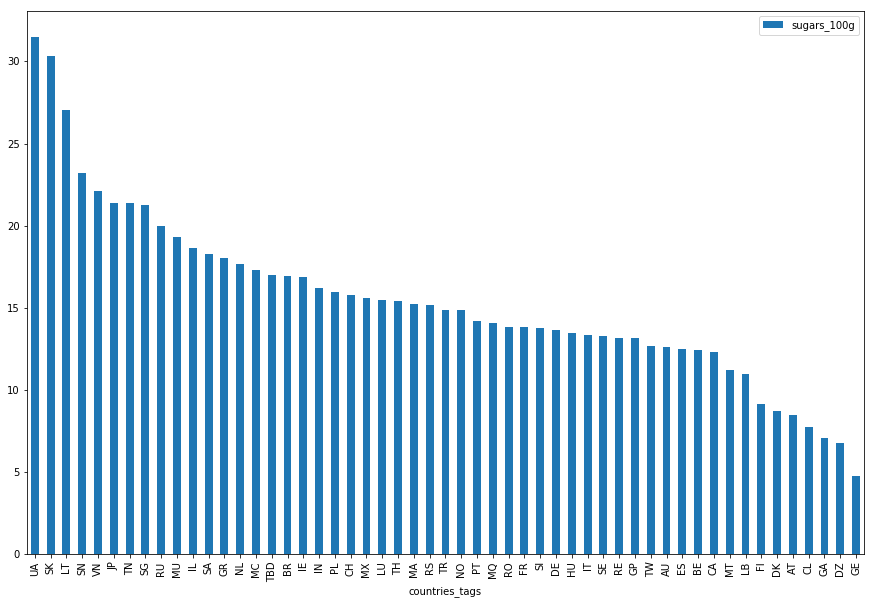

In [28]:
sugar = means[['sugars_100g']].dropna()
sugar = sugar[sugar['sugars_100g'] <= 100]
sugar = sugar.sort_values(by=['sugars_100g'], ascending=False)
sugar = sugar[counted['sugars_100g'] > 20]
sugar.plot.bar(figsize=(15,10))

We can see which countries consume the most sugars according to our datas.

/home/pirate/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


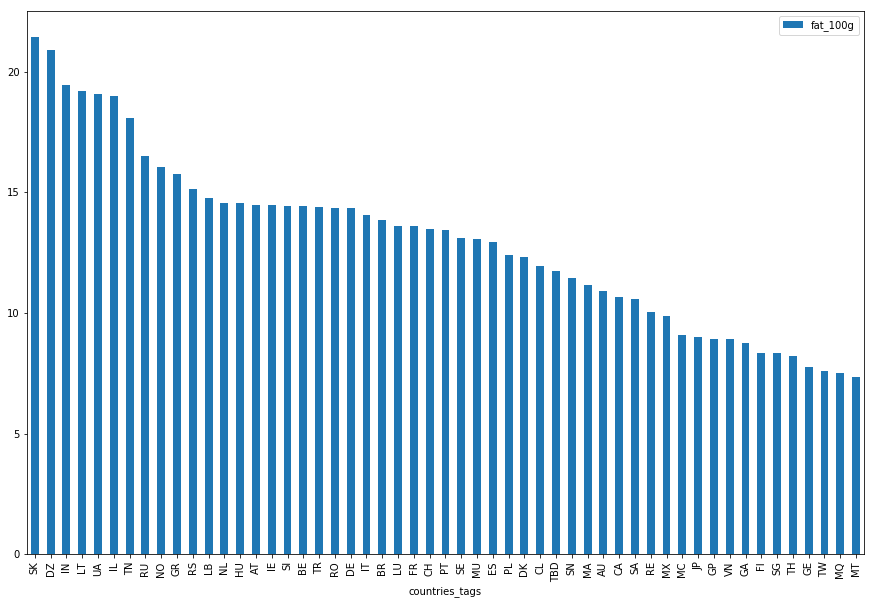

In [29]:
fat = means[['fat_100g']].dropna()
fat = fat[fat['fat_100g'] <= 100]
fat = fat.sort_values(by=['fat_100g'], ascending=False)
fat = fat[counted['fat_100g'] > 20]
fat.plot.bar(figsize=(15,10))

We can see which countries consume the most fat according to our datas. We can see some correlations (Slovakia are on the top of the ranking for each aspect) and some independant values (Germany use a lot of fat but not so much sugar).

We get the union of the sugar and fat datas to filter some other results.

In [106]:
indexes = pd.DataFrame(np.concatenate((sugar.index.values,fat.index.values)))
indexes = indexes.drop_duplicates()

In [107]:
overweight_datas = overweight[overweight['Year'] == 2016]
overweight_datas['Entity'] = overweight_datas['Entity'].apply(lambda x: get_tag(str(x).lower().strip()))
overweight_datas = overweight_datas[overweight_datas['Entity'] != 'TBD']
overweight_datas = overweight_datas.set_index(['Entity'])
overweight_datas = overweight_datas[['Indicator']]
overweight_datas = overweight_datas.sort_values(by=['Indicator'], ascending=False)
overweight_datas = overweight_datas[overweight_datas.index.isin(indexes[0])]

overweight_datas


/home/pirate/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Indicator
Entity,
TR,32.1
LB,32.0
CA,29.4
AU,29.0
MX,28.9
MT,28.9
CL,28.0
DZ,27.4
TN,26.9


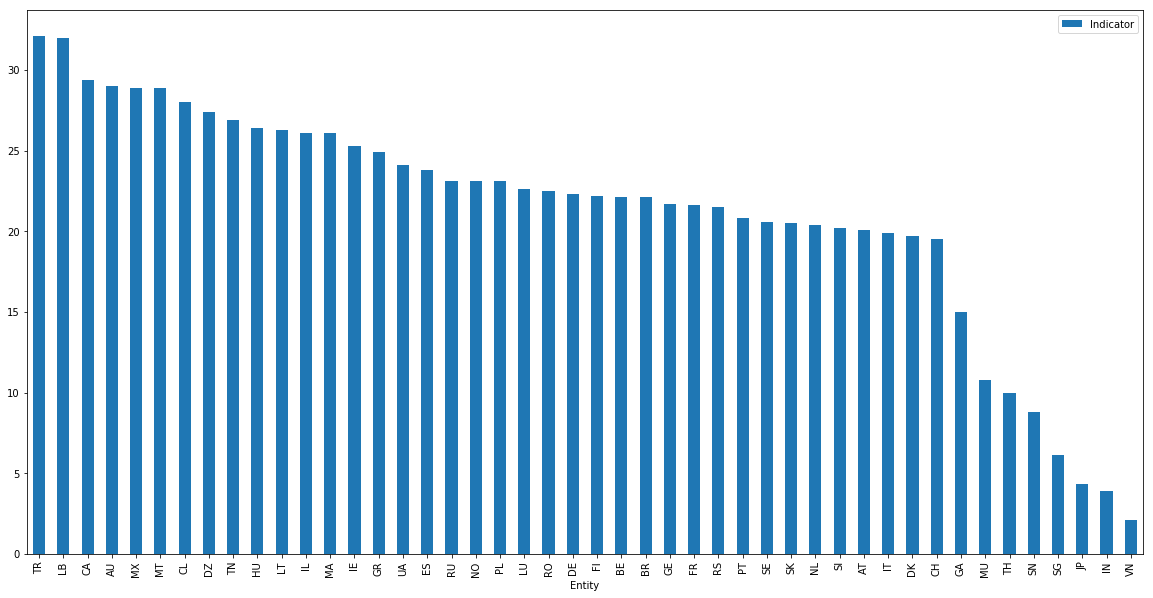

In [93]:
overweight_datas.plot.bar(figsize=(20,10))

As we can see : It is difficulte to find a really correlation between the previous obsrvations (sugar & fat) and the obesity percentage display above. For example the slovakia is in the mean (for the obesity) but not really for the sugar & fat. That is only a guess we have to provide a scatter plot to proove it.

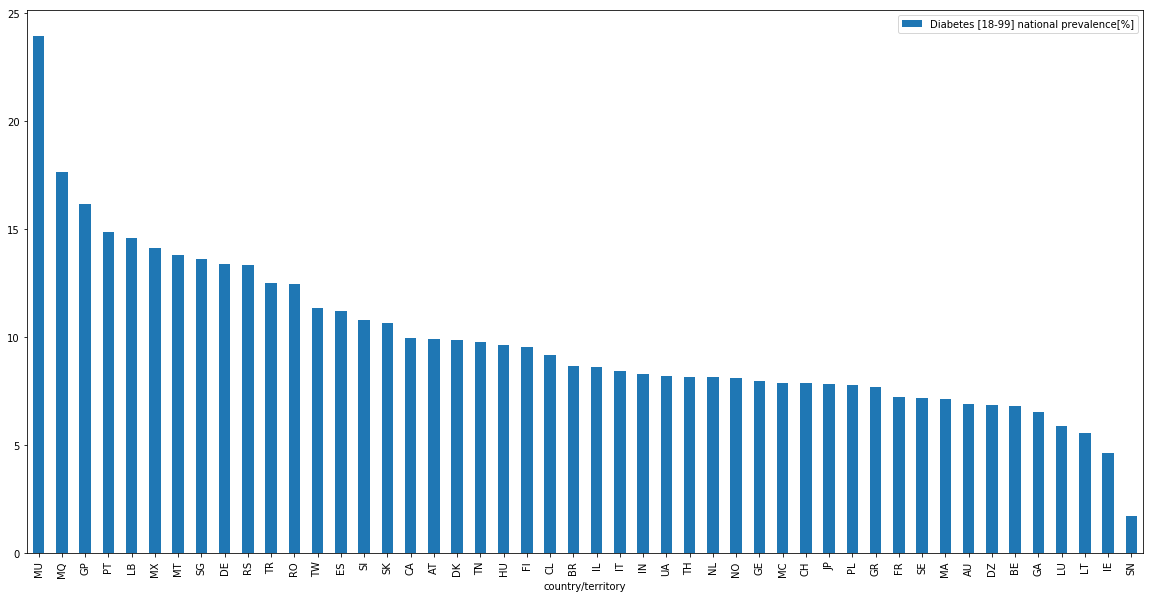

In [104]:
to_drop=['prev', 'Unnamed: 5']
diab = diabetes.drop(to_drop, axis=1)
diab.columns
diab=diab[['country/territory', 'Diabetes [18-99] national prevalence[%]']]
diab['Diabetes [18-99] national prevalence[%]'] = pd.to_numeric(diab['Diabetes [18-99] national prevalence[%]'].str[:-1])
diab['country/territory'] = diab['country/territory'].apply(lambda x: get_tag(str(x).lower().strip()))
diab = diab[diab['country/territory'] != 'TBD']
diab.set_index('country/territory', inplace=True)
diab = diab[diab.index.isin(indexes[0])]
diab= diab.sort_values(by=['Diabetes [18-99] national prevalence[%]'],ascending=False)
diab.plot.bar(figsize=(20,10))

Like for the obesity : it is difficulte to find a really correlation between the previous obsrvations (sugar & fat) and the diabetes percentage display above. Same example : slovakia is in just after the middle but not really for the sugar & fat. Once more that is only a guess we have to provide a scatter plot to proove it.

### Summarize
We selected the datas who have an interest for us. We parse them to be able to get some results from it. We already get some results concerning alimentation quality of different countries. The really next step is to prove if a correlation exists between our results. (We have some guess but we have to provide a scatter plot to proove it)

### What comes next

Fistly we reoriented our approach of our study. We decides to globalized our approach and not focus our work on the european countries. Indeed not too many countries have relevant datas so we can include all of them.

We spend a lot of time on the dataset clean. So we focus our first work on the countries part. We will focus on the food quality in the next steps.

#### Research questions 
As we discussed above we did not yet work on the food quality. So we are not able to answer our research questions for the moment. We have to extract more datas and try to find a correlation with the ones we lready get. 